In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Function for graph

In [2]:
import plotly.graph_objects as go
def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

# Choose between OriginalSet and AugmentedSet

In [3]:
# Set the path to your main folder containing the class folders
main_folder = "/kaggle/input/bananalsd/BananaLSD/AugmentedSet"
main_folder = "/kaggle/input/bananalsd/BananaLSD/OriginalSet"

In [4]:
# Set the desired ratio for train and test
train_ratio = 0.8  # 80% for training, 20% for testing

# Create dictionaries to store train and test file paths
train_files = {}
test_files = {}

random.seed(42)

In [5]:
# Iterate over the class folders
for class_folder in os.listdir(main_folder):
    class_path = os.path.join(main_folder, class_folder) 
    images = os.listdir(class_path) #A list containing images names for each class
    
    # Shuffle the images randomly
    random.seed(42)    
    random.shuffle(images)
    
    # Determine the split index based on the train ratio
    split_index = int(len(images) * train_ratio)
    
    # Assign images to train and test dictionaries
    train_files[class_folder] = images[:split_index] #Dictionary containing className: List of images
    test_files[class_folder] = images[split_index:]

In [6]:
# Define image dimensions and number of classes
image_width, image_height = 224, 224
num_classes = len(train_files)
print(num_classes)

4


In [7]:
# Create empty arrays to store the image data and labels
train_data = []
train_labels = []
test_data = []
test_labels = []

# Load and preprocess train set images
for class_folder, images in train_files.items():
    for image in images:
        image_path = os.path.join(main_folder, class_folder, image)
        img = load_img(image_path, target_size=(image_width, image_height))
        img_array = img_to_array(img)
        train_data.append(img_array)
        train_labels.append(class_folder)

# Load and preprocess test set images
for class_folder, images in test_files.items():
    for image in images:
        image_path = os.path.join(main_folder, class_folder, image)
        img = load_img(image_path, target_size=(image_width, image_height))
        img_array = img_to_array(img)
        test_data.append(img_array)
        test_labels.append(class_folder)

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/opt/conda/lib/python3.10/site-packages/PIL/JpegImagePlugin.py:835: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


In [8]:
# Create a dictionary to map class folder names to integer labels
class_label_map = {class_folder: i for i, class_folder in enumerate(train_files.keys())}

# Convert the train and test labels to integer labels
train_labels = np.array([class_label_map[label] for label in train_labels]) 
test_labels = np.array([class_label_map[label] for label in test_labels])


# Convert class labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [9]:
from tensorflow.keras.applications import ResNet50, MobileNetV3Large, MobileNetV3Small
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
# Custom metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
model = tf.keras.backend.clear_session()
# Create a new model by adding the ResNet model on top of your existing layers
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10

history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))


display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')

display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')

Epoch 1/10
24/24 [==============================] - 12s 180ms/step - loss: 2.5184 - accuracy: 0.7353 - val_loss: 0.4264 - val_accuracy: 0.8889
Epoch 2/10
24/24 [==============================] - 2s 85ms/step - loss: 0.2299 - accuracy: 0.9332 - val_loss: 0.2830 - val_accuracy: 0.9418
Epoch 3/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0857 - accuracy: 0.9746 - val_loss: 0.2988 - val_accuracy: 0.9312
Epoch 4/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0446 - accuracy: 0.9840 - val_loss: 0.2086 - val_accuracy: 0.9630
Epoch 5/10
24/24 [==============================] - 2s 72ms/step - loss: 0.0204 - accuracy: 0.9906 - val_loss: 0.2198 - val_accuracy: 0.9577
Epoch 6/10
24/24 [==============================] - 2s 73ms/step - loss: 0.0163 - accuracy: 0.9933 - val_loss: 0.2133 - val_accuracy: 0.9630
Epoch 7/10
24/24 [==============================] - 2s 72ms/step - loss: 0.0141 - accuracy: 0.9933 - val_loss: 0.2144 - val_accuracy: 0.9577
Epoch 8/10


In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

6/6 [==============================] - 0s 57ms/step - loss: 0.2993 - accuracy: 0.9312
Test Loss: 0.29934459924697876
Test Accuracy: 0.9312169551849365


In [13]:
# Evaluate the model and get the predicted labels
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
confusion = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convert the confusion matrix to a NumPy array
confusion = confusion.numpy()

6/6 [==============================] - 1s 53ms/step


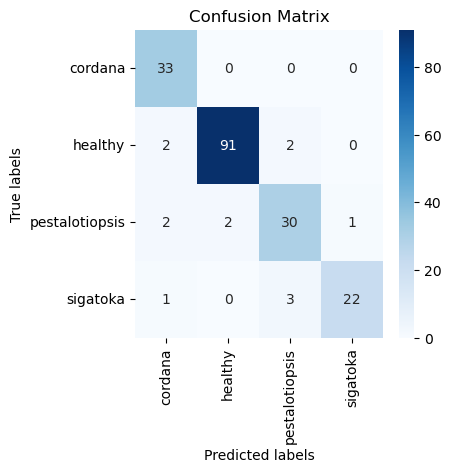

In [14]:
# Display the confusion matrix
plt.figure(figsize=(num_classes, num_classes))
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
# Modify the labels
new_x_labels = ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']
new_y_labels = ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']
# Set the modified labels
ax.set_xticklabels(new_x_labels, rotation=90)
ax.set_yticklabels(new_y_labels, rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
#export the model
model.save('banana_custom_resnet.h5')

In [17]:
!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

# Define the model for pruning
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=2000,
                                                               end_step=10000)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# Compile the pruned model
model_for_pruning.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Train the pruned model
model_for_pruning.fit(train_data, train_labels, batch_size=32, epochs=10, validation_data=(test_data, test_labels))

# Strip pruning wrappers
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# Convert to TFLite with quantization
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_data).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

# Save the converted model
with open('banana_model_pruned_int8_quant.tflite', 'wb') as f:
    f.write(tflite_model)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.3 MB/s eta 0:00:00
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32/3329117188.py", line 22, in <module>
      model_for_pruning.fit(train_data, train_labels, batch_size=32, epochs=10, validation_data=(test_data, test_labels))
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py", line 307, in call
      update_mask = utils.smart_cond(training, add_update, no_op)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/keras/utils.py", line 51, in smart_cond
      if isinstance(pred, variables.Variable):
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/keras/utils.py", line 55, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py", line 289, in add_update
      with tf.control_dependencies([
Node: 'sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32/3329117188.py", line 22, in <module>
      model_for_pruning.fit(train_data, train_labels, batch_size=32, epochs=10, validation_data=(test_data, test_labels))
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py", line 307, in call
      update_mask = utils.smart_cond(training, add_update, no_op)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/keras/utils.py", line 51, in smart_cond
      if isinstance(pred, variables.Variable):
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/keras/utils.py", line 55, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py", line 289, in add_update
      with tf.control_dependencies([
Node: 'sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [Prune() wrapper requires the UpdatePruningStep callback to be provided during training. Please add it as a callback to your model.fit call.] [Condition x >= y did not hold element-wise:] [x (sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/ReadVariableOp:0) = ] [0] [y (sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/y:0) = ] [1]
	 [[{{node sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[sequential/resnet50/prune_low_magnitude_conv5_block1_1_relu/assert_greater_equal/Assert/AssertGuard/pivot_f/_2771/_3217]]
  (1) INVALID_ARGUMENT:  assertion failed: [Prune() wrapper requires the UpdatePruningStep callback to be provided during training. Please add it as a callback to your model.fit call.] [Condition x >= y did not hold element-wise:] [x (sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/ReadVariableOp:0) = ] [0] [y (sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/y:0) = ] [1]
	 [[{{node sequential/resnet50/prune_low_magnitude_conv1_pad/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_63555]